In [1]:
import sys
from pathlib import Path

current_path = Path.cwd()
root = current_path.parent
sys.path.append(str(root))

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Normalization, RandomFlip, RandomRotation, RandomZoom, Dense, Dropout, Embedding

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 28
patch_size = 7
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
learning_rate = CustomSchedule(projection_dim)
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 12
mlp_head_units = [
    256,
    128,
]

In [4]:
class AugmentationResize(keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, images):
        batch_size = images.shape[0]
        image_size = images.shape[1]
        resized = tf.reshape(tf.convert_to_tensor(images), [1, image_size, image_size, 1])
        return resized
    
    def adapt(self, data, batch_size=None, steps=None):
        super().adapt(data, batch_size, steps)
    
from keras.layers import Reshape, Rescaling

data_augmentation = keras.Sequential(
    [
        Normalization(),
        Reshape((28, 28, 1), input_shape=(28, 28)),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.02),
        RandomZoom(height_factor=0.2, width_factor=0.2),
        Rescaling(1./255, input_shape=(28, 28, 1))
    ],
    name="data_augmentation",
)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=keras.activations.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def mlp_nontrainable(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=keras.activations.gelu, trainable=False)(x)
        x = Dropout(dropout_rate, trainable=False)(x)
    return x

In [6]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = images.shape
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size


        patches = tf.image.extract_patches(images, 
                                           sizes=[1, self.patch_size, self.patch_size, 1], 
                                           strides=[1, self.patch_size, self.patch_size, 1], 
                                           rates=[1, 1, 1, 1], 
                                           padding='VALID')
        
        patches = tf.experimental.numpy.reshape(patches,
                             (
                                 -1,
                                 num_patches_h * num_patches_w,
                                 self.patch_size * self.patch_size * channels,
                             ), order='C')
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size":self.patch_size})
        return config

(28, 28)
(1, 28, 28, 1)


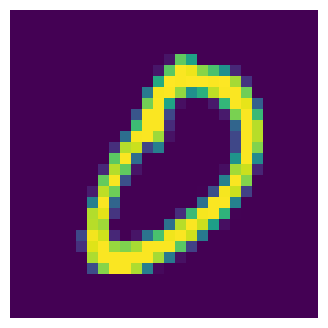

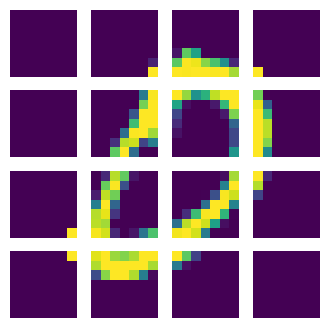

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

print(image.shape)
resized_image = tf.reshape(
    tf.convert_to_tensor([image]), [1, image_size, image_size, 1])

print(resized_image.shape)



patches = Patches(patch_size)(resized_image)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
from keras.layers import Embedding

class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.proejction = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.expand_dims(
            tf.experimental.numpy.arange(0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.proejction(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
    
    def get_config(self):
        config = super().get_config()
        config.update({"num_patches":self.num_patches})
        return config

In [9]:
from keras.layers import LayerNormalization, MultiHeadAttention, Add, Flatten,Dropout, Dense

def create_vit_classifier(input_shape):

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = Add()([x3, x2])

    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = Dense(10)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
from layers.parma import Parma

def run_experiment(model, checkpoint_filepath):
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9, 
        beta_2=0.98,
        epsilon=1e-9
    )

    parma = Parma(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ]
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy:{round(accuracy * 100, 2)}%")

    return history

def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_"+item], label="val_"+item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
vit_classifier = create_vit_classifier((image_size, image_size))
checkpoint_filepath="./tmp/mla.weights.h5"
history = run_experiment(vit_classifier, checkpoint_filepath)
plot_history(history, "loss")
plot_history(history, "accuracy")

Epoch 1/20


KeyboardInterrupt: 

In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#learning_rate = 0.001
#weight_decay = 0.0001
batch_size = 512
num_epochs = 20
image_size = 28
patch_size = 7
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
learning_rate = CustomSchedule(projection_dim)
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 12
mlp_head_units = [
    1024,
    64,
]

In [13]:
from keras.layers import LayerNormalization, Add, Flatten,Dropout, Dense
from layers.selective_attention import SelectiveAttention

def create_vit_classifier_with_sa(input_shape):

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = SelectiveAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(query=x1, key=x1, value=x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp_nontrainable(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = Add()([x3, x2])

    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(rate=0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = Dense(10)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
vit_classifier_with_sa = create_vit_classifier_with_sa((image_size, image_size))
checkpoint_filepath = "./tmp/sa.weights.h5"
history2 = run_experiment(vit_classifier_with_sa, checkpoint_filepath)
plot_history(history2, "loss")
plot_history(history2, "accuracy")

Epoch 1/20
211/211 [==============================] - 1082s 5s/step - loss: 3.5302 - accuracy: 0.1116 - val_loss: 2.2419 - val_accuracy: 0.1682
Epoch 2/20
151/211 [====================>.........] - ETA: 5:13 - loss: 2.3482 - accuracy: 0.1520

KeyboardInterrupt: 